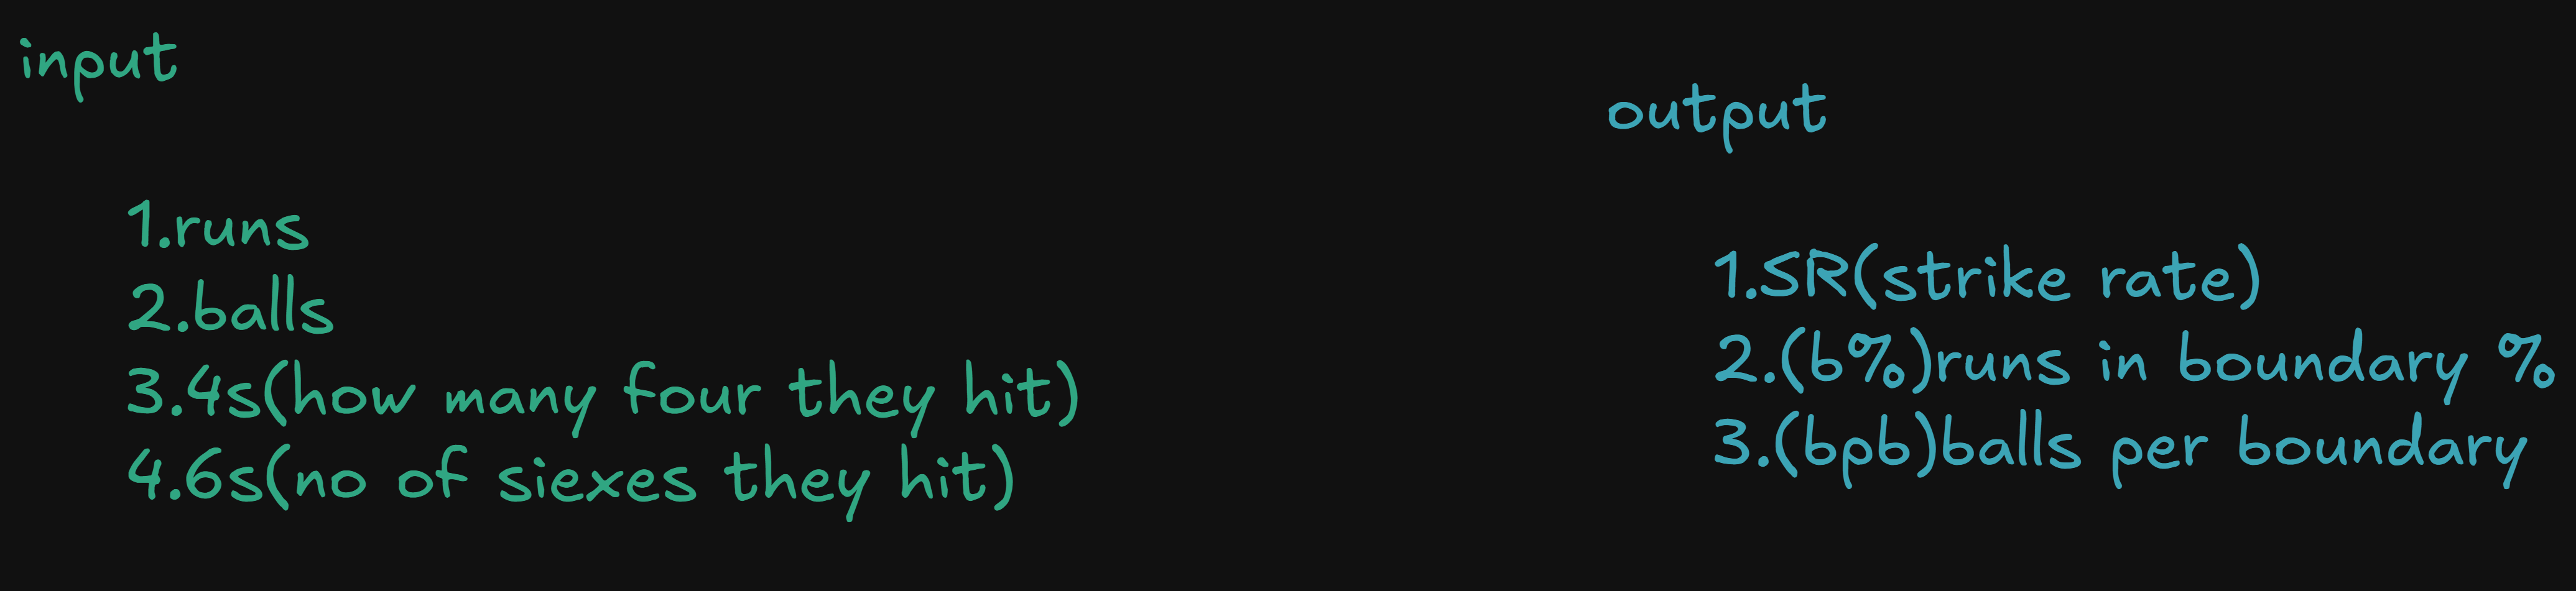

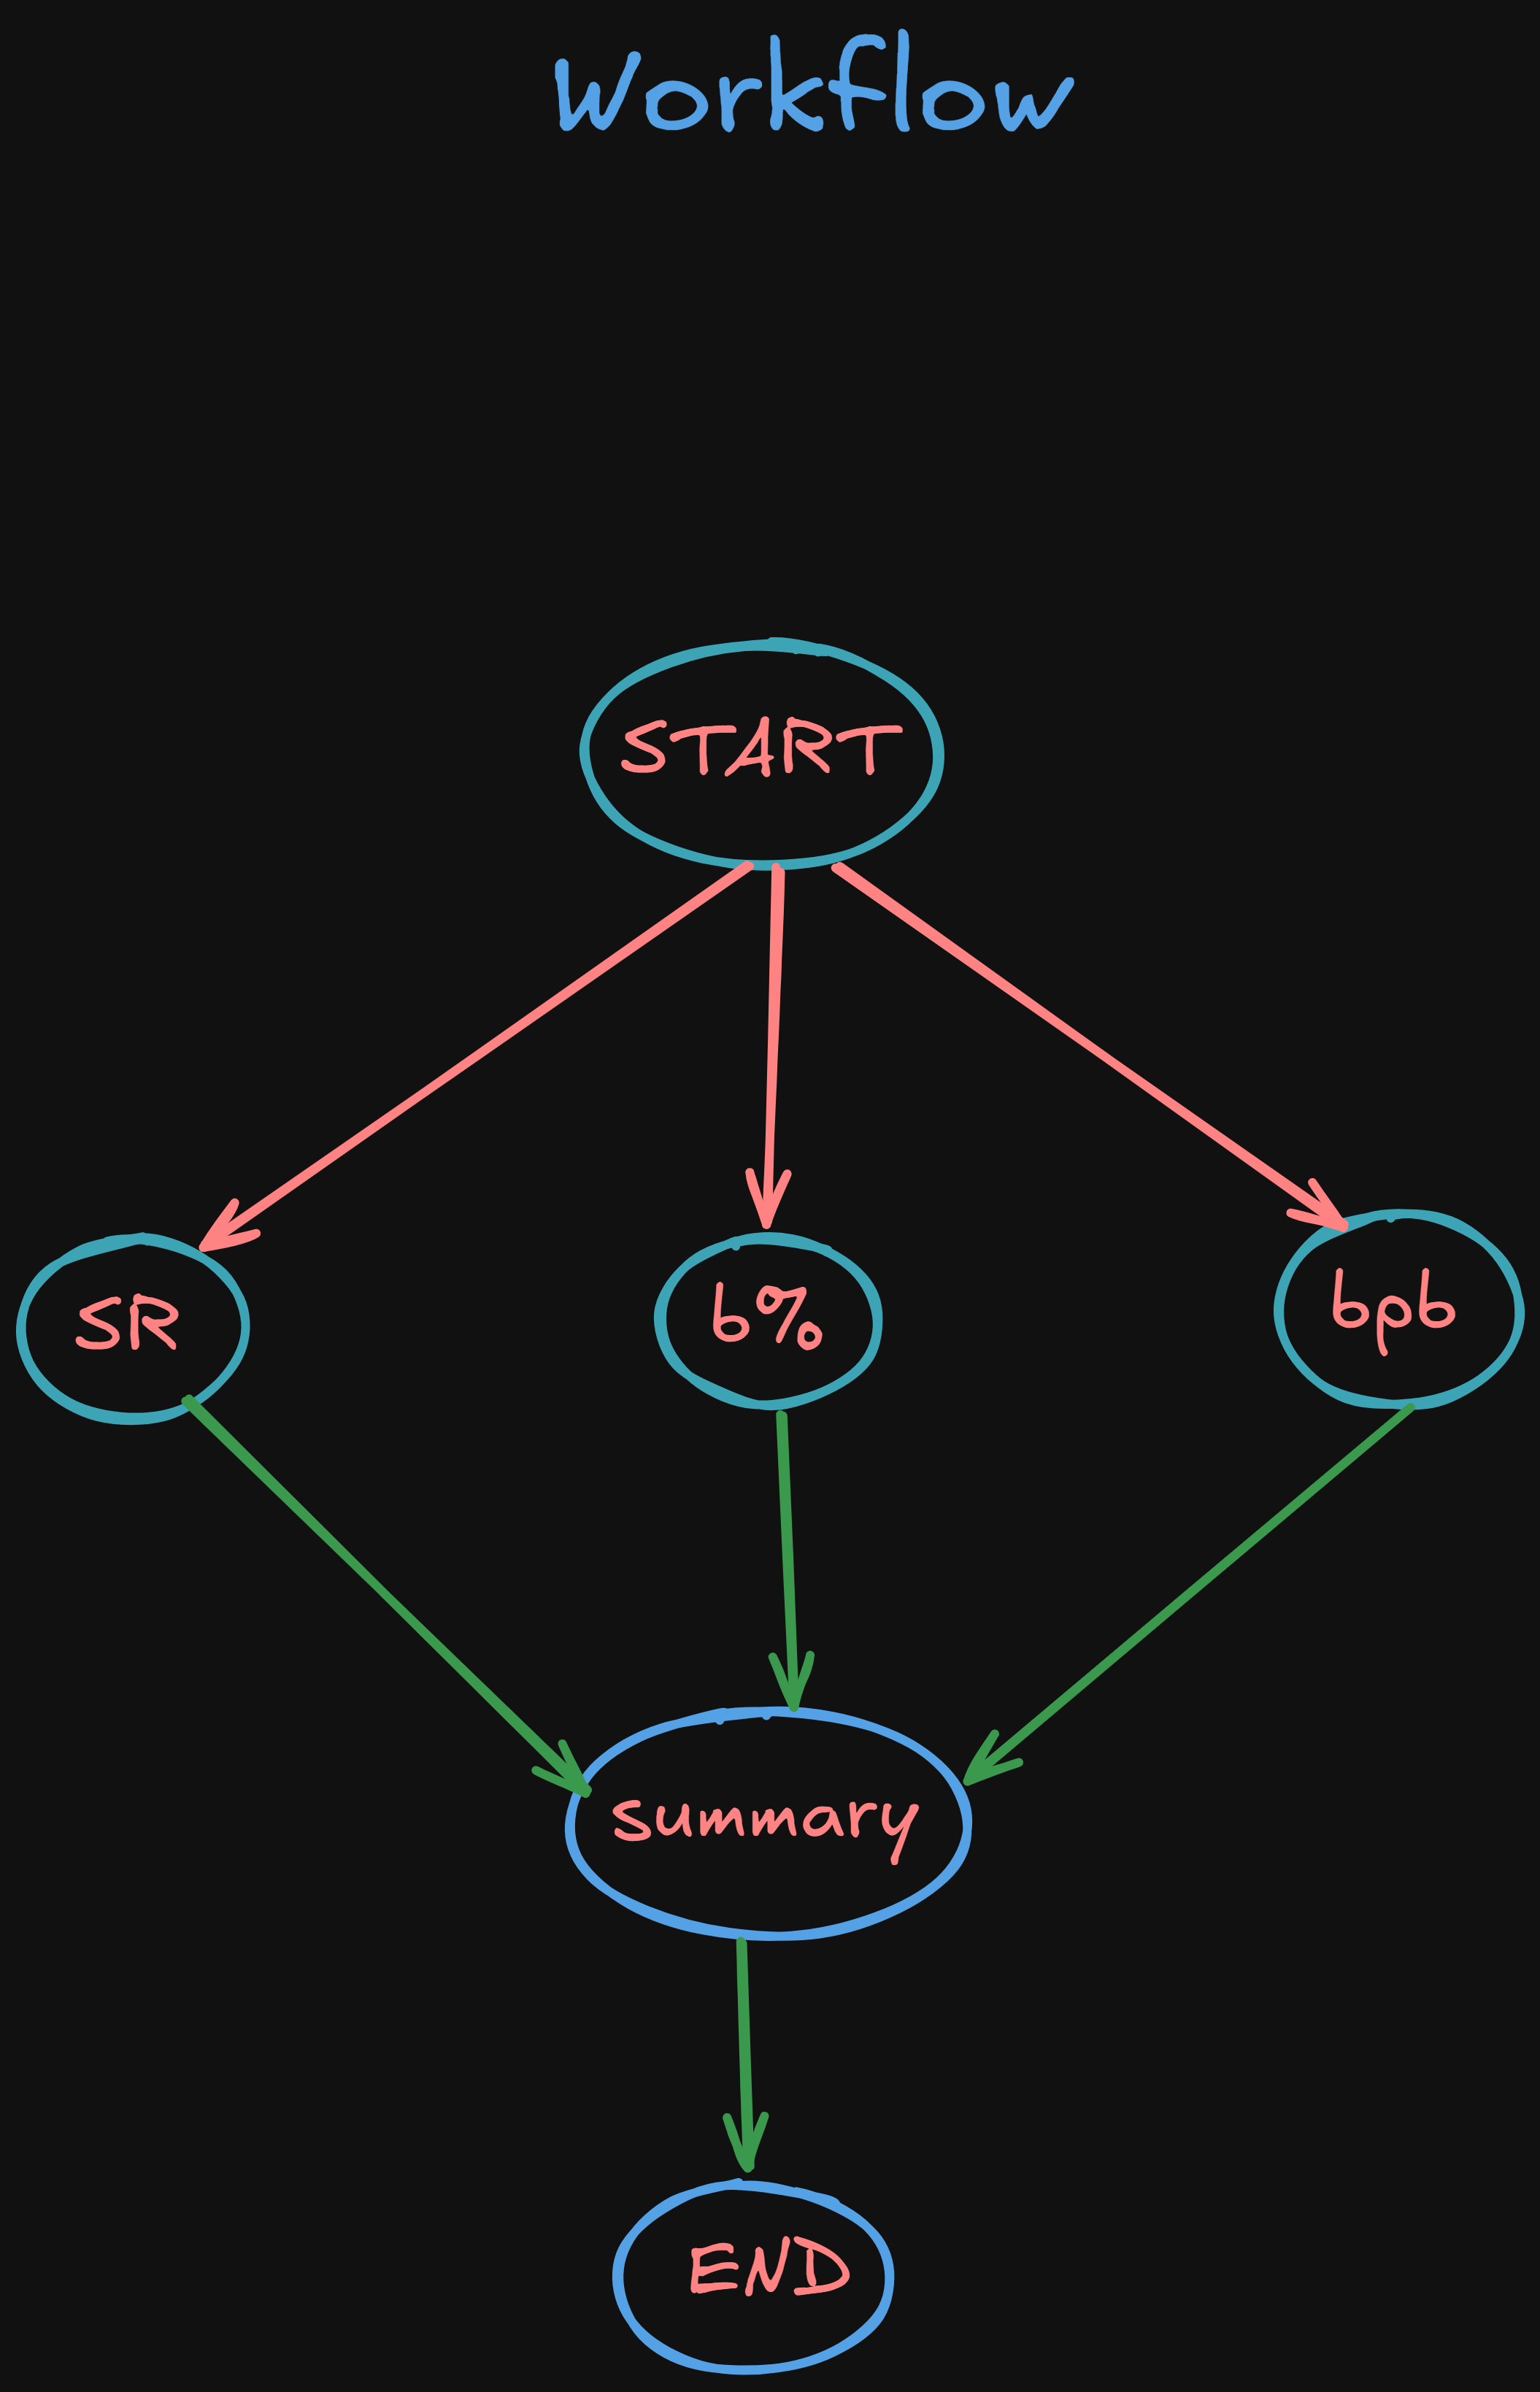

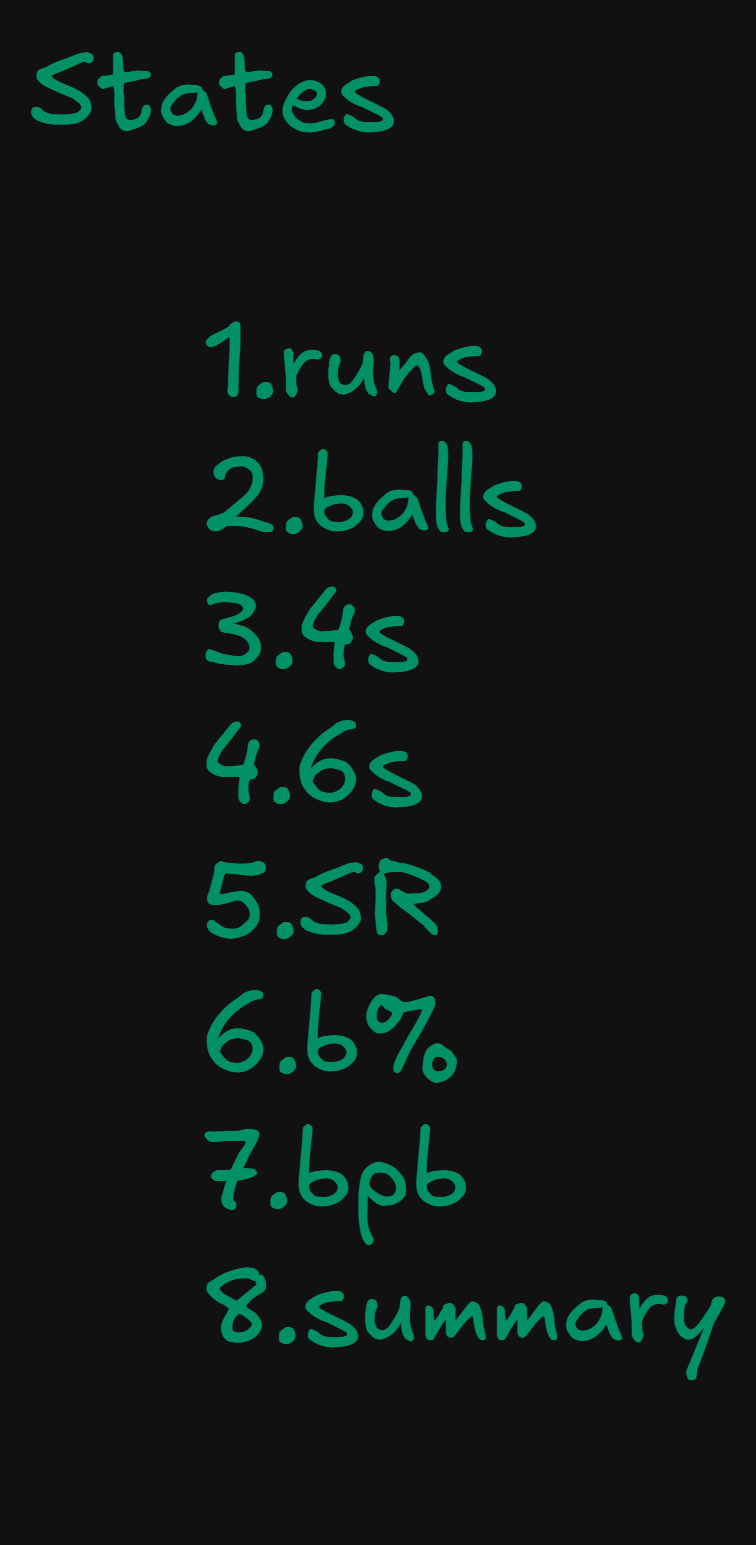

# <b> Step by Step 

Step1:-importing libraries

In [12]:
from langgraph.graph import StateGraph
from typing import TypedDict

step2:-creating state

In [ ]:
class BatsmanState(TypedDict):

    # states that we have
    runs:int
    balls:int
    fours:int
    sixes:int

    # states that we will calucate
    sr:float
    bpb:float
    boundary_percent:float
    summary:str



step3:-initializing the graph

In [15]:
graph=StateGraph(BatsmanState)

step4:-adding nodes

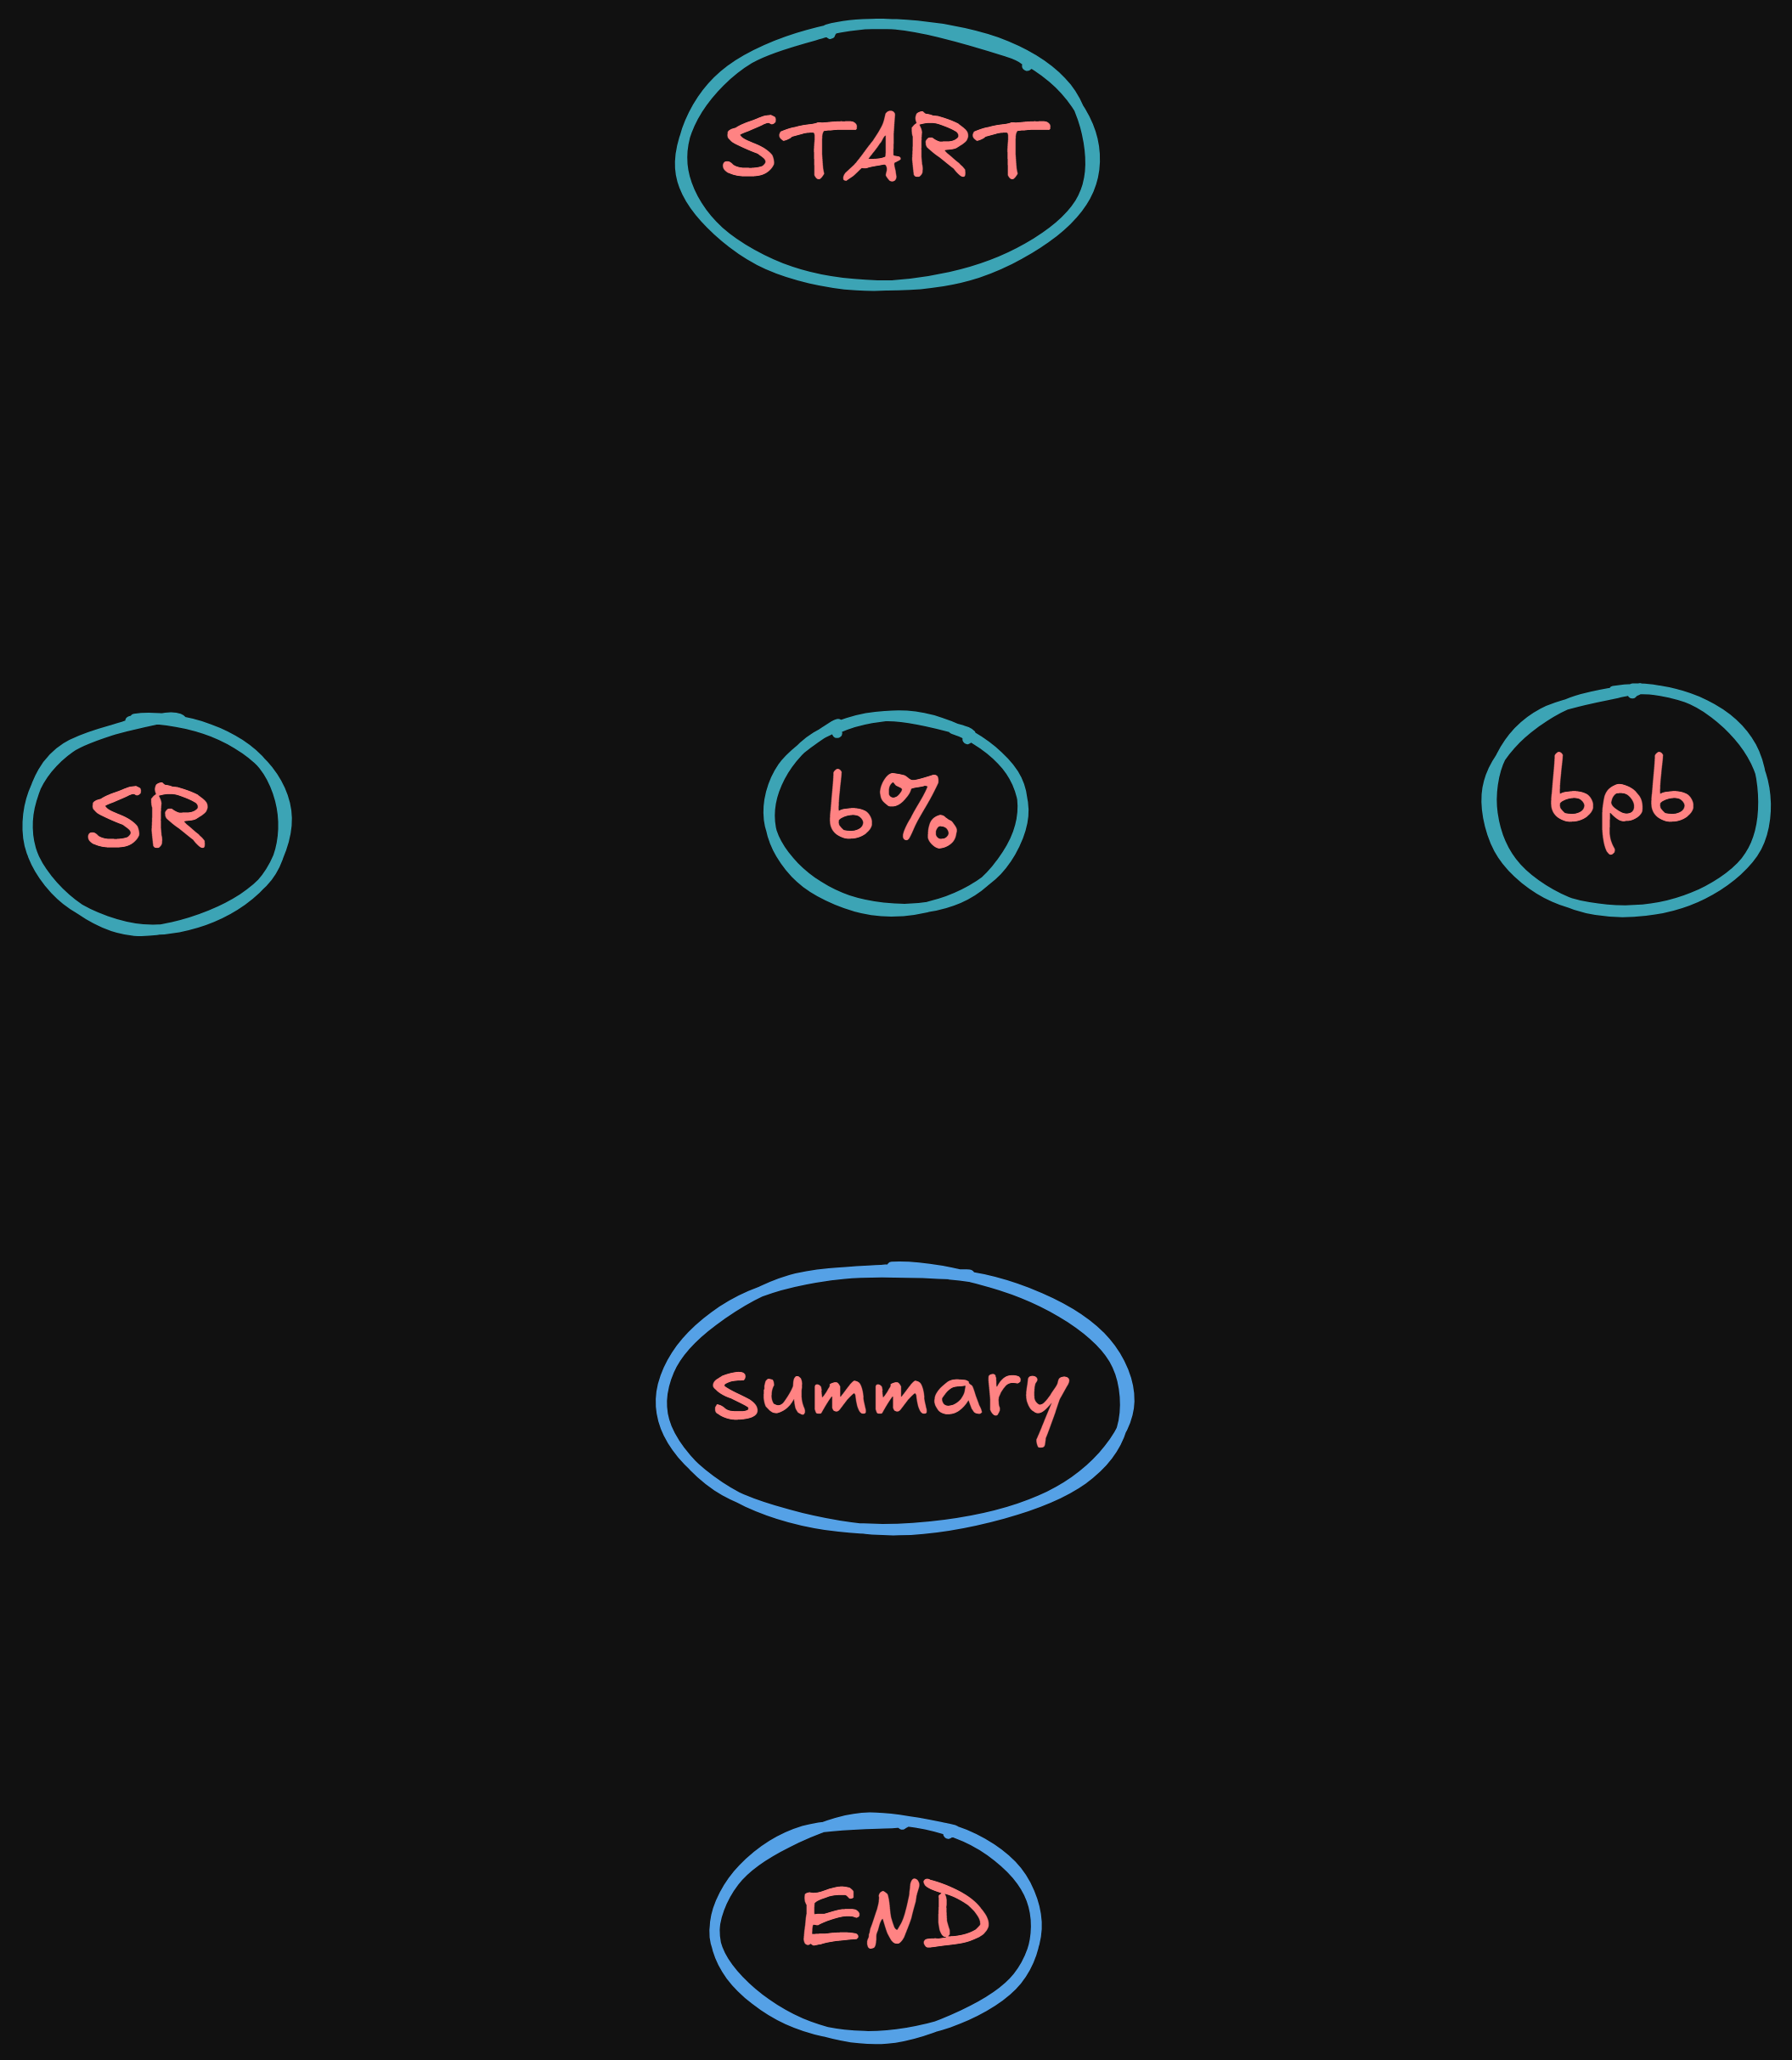

In [16]:
# calculating sr
def calculate_sr(state:BatsmanState):
    sr=(state['runs']/state['balls'])/100
    state['sr']=sr

    return state

In [17]:
# calculating bpb
def calculate_bpb(state:BatsmanState):
    bpb=state['balls']/(state['fours']+state['sixes'])
    state['bpb']=bpb
    return state

In [18]:
# calucalting boundary percent
def calculate_boundary_percent(state:BatsmanState):
    boundary_percent=(((state['fours']+state['sixes']))/state['runs'])*100
    state['boundary_percent']=boundary_percent

    return state

In [19]:
# creating summary
def summary(state:BatsmanState):
    summary=f"""    
Strike Rate={state['sr']}\n
Balls per boundary={state['bpb']}\ng
Boundary percent={state['boundary_percent']}

"""
    state['summary']=summary

    return state

In [ ]:
graph.add_nodes('calculate_sr',calculate_sr)
graph.add_nodes('calculate_bpv',calculate_bpb)
graph.add_nodes('calculate_boundary_percent',calculate_boundary_percent)
graph.add_nodes('summary',summary)


step5:-adding edges

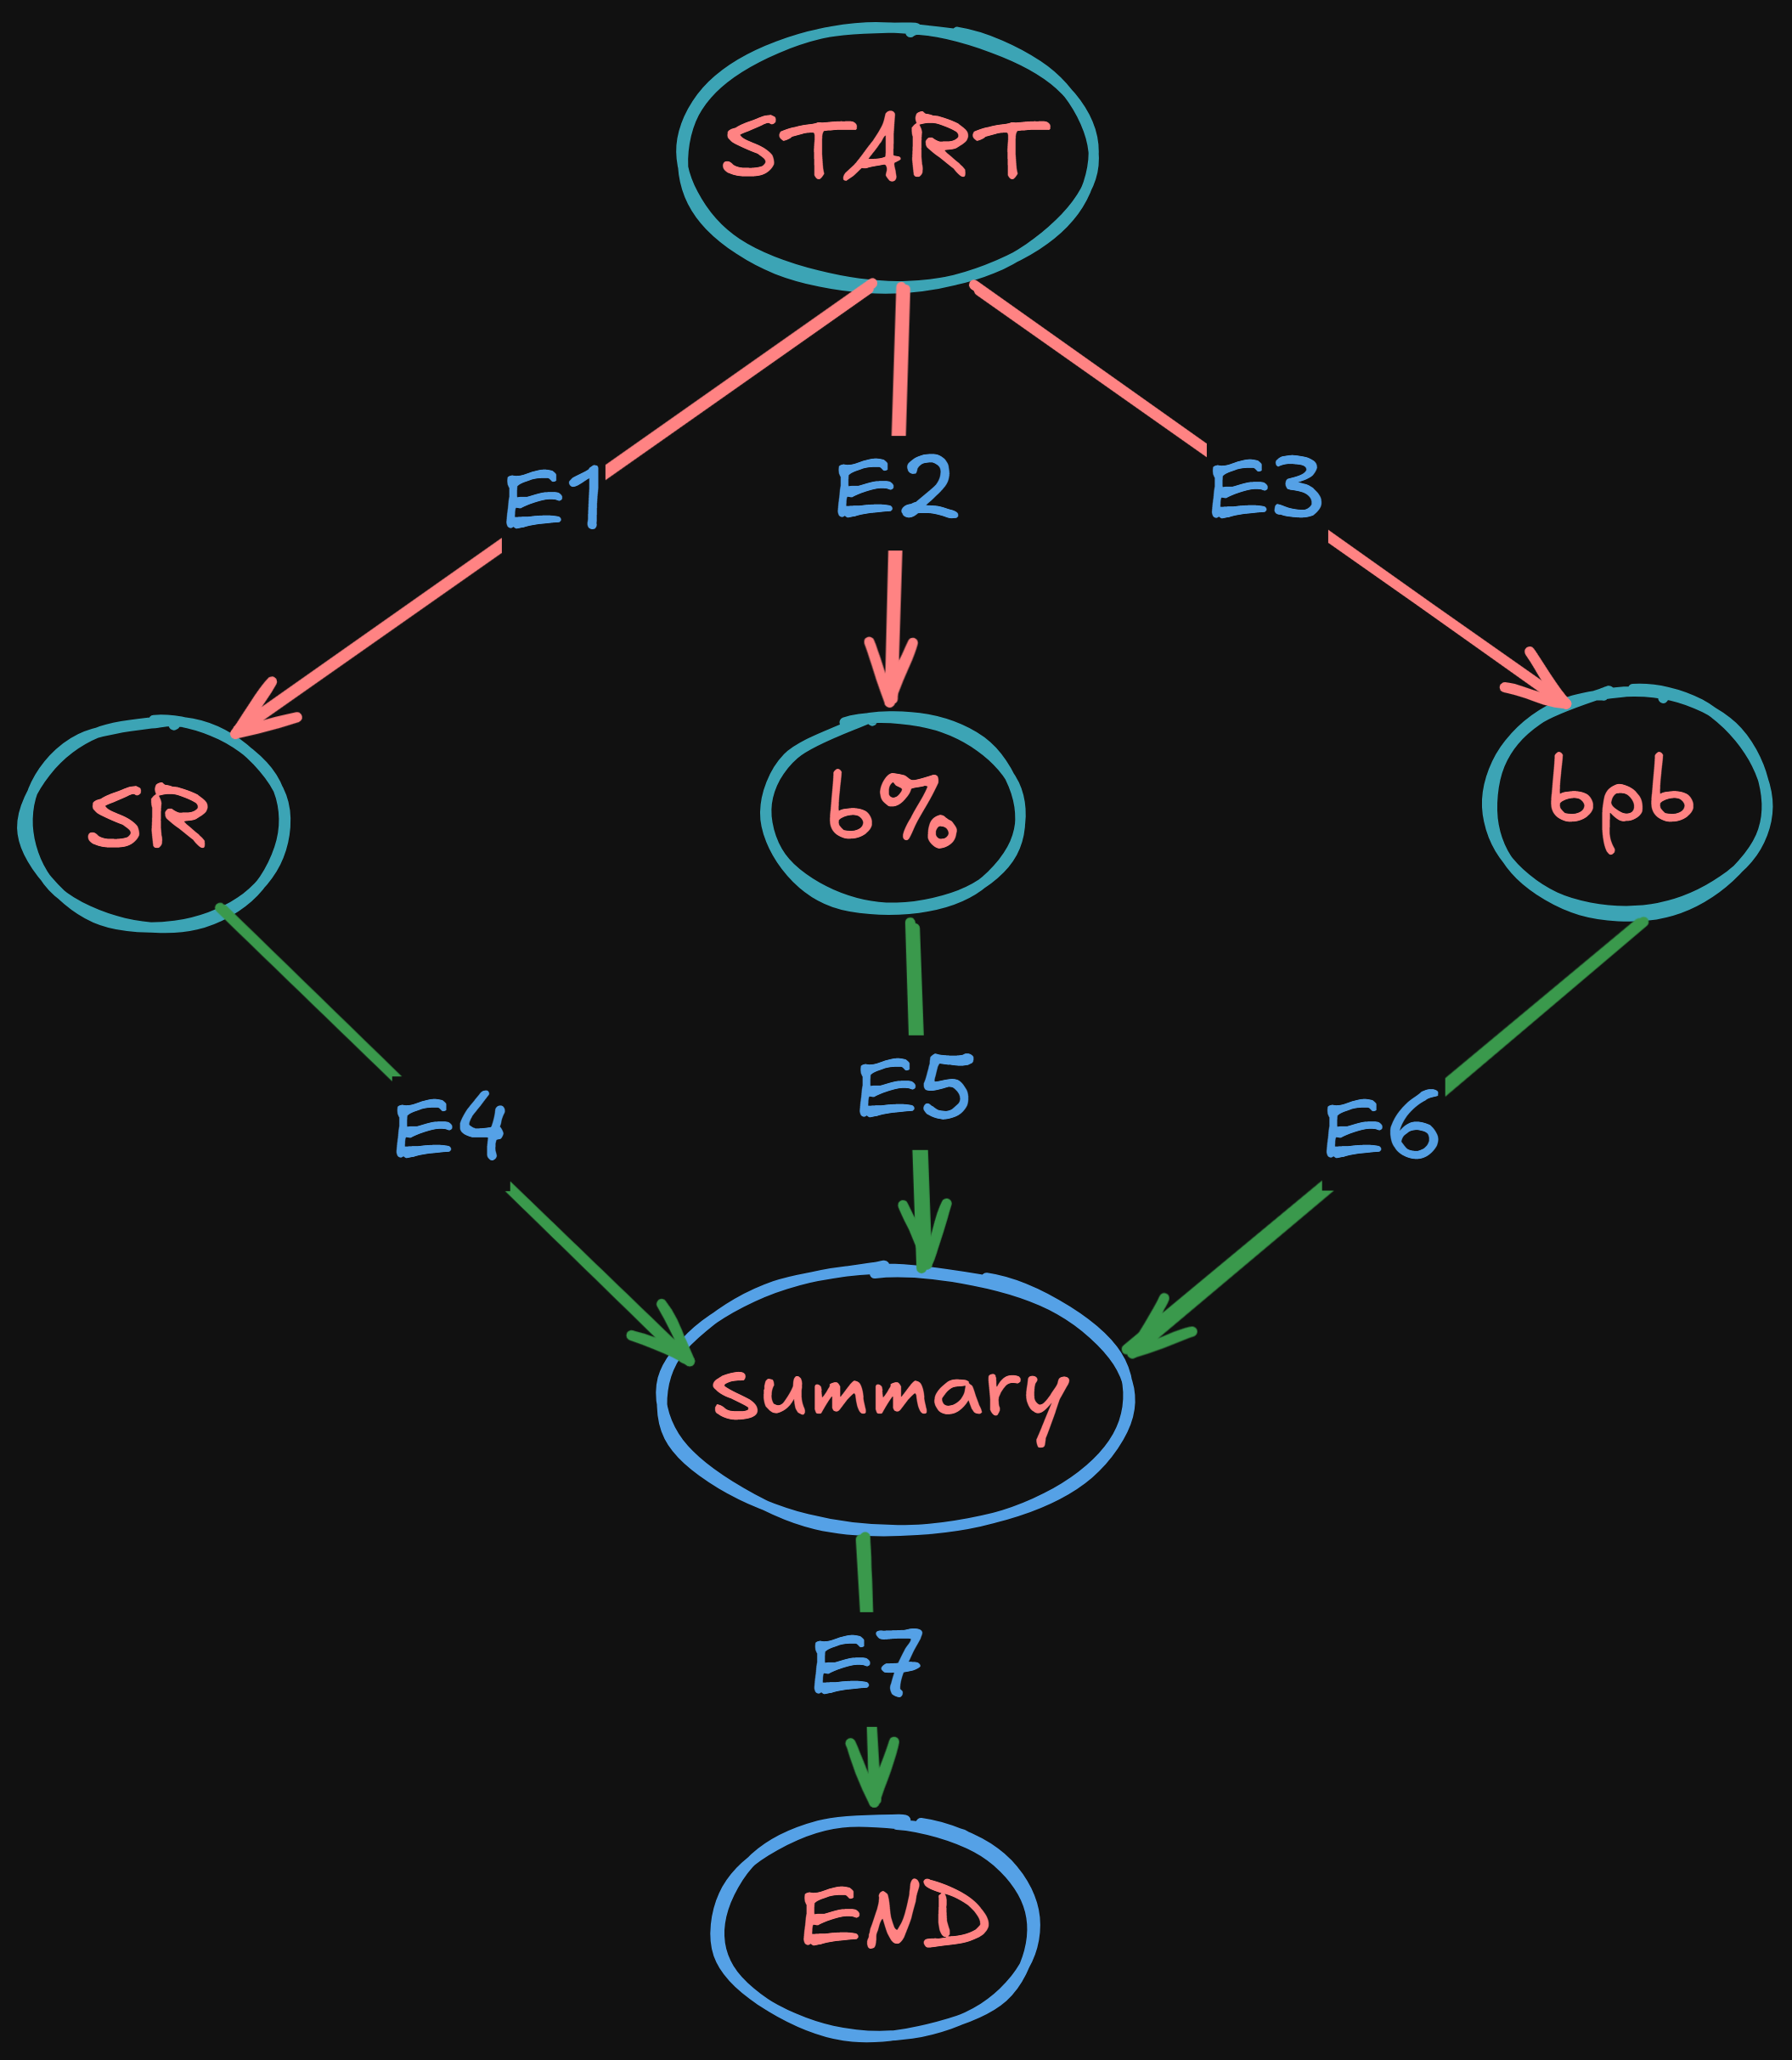

In [ ]:
graph.add_edge(START,'calculate_sr')
graph.add_edge(START,'calculate_bpb')
graph.add_edge(START,'calculate_boundary_percent')

graph.add_edge('calculate_sr','summary')
graph.add_edge('calculate_bpb','summary')
graph.add_edge('calculate_boundary_percent','summary')

graph.add_edge('summary',END)
